<a href="https://colab.research.google.com/github/Zain506/Similarity/blob/main/notebooks/medclipsam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MedCLIP-SAM

[Research Paper](https://arxiv.org/pdf/2403.20253)



In [28]:
from datasets import load_dataset

ds = load_dataset("adishourya/MEDPIX-ClinQA") # Import MedPIX dataset
train_valid = ds["train"].train_test_split(test_size=0.15)
training = train_valid["train"].select(range(1024))
validation = train_valid["test"]
print(training)

Dataset({
    features: ['image_id', 'mode', 'case_id', 'question', 'answer'],
    num_rows: 1024
})


In [29]:
import torch
device  = "cuda" if torch.cuda.is_available() else "cpu"
print("Processor: ", device)

Processor:  cpu


## There are 3 components of the CLIP-style architecture
1. Text Encoder (PubMedBERT)
2. Image Encoder (ViT)
3. Model mapping encoded images and text into the shared embedding space

**BiomedCLIP from open_clip contains all of them, and that is what MedCLIP-SAM aims to fine-tune**

In [30]:
%%capture cap
%pip install open_clip_torch # run ``cap.show()`` in order to see the output here

In [31]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
# model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [32]:
import torch
from torch.utils.data import DataLoader
# In this case the data in the dataset isn't in tensor form - so we need to define a custom collate_fn to convert them into tensors
def collate_fn(batch): # Define custom collate_fn to convert relevant data in each batch to tensor
  images = torch.stack([preprocess(x['image_id']) for x in batch])
  texts = tokenizer([f"Prompt: {x['question']} \nAnswer: {x['answer']}" for x in batch])

  return images, texts

train_loader = DataLoader(training, batch_size=16, shuffle=True, collate_fn=collate_fn) # Each tensor in the train_loader will have dimension `batch_size` in axis=0

In [40]:
# Iterate over images, texts in train_loader
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW( # Freezing a part of the model requires us to set requires_grad=False
    model.parameters(), # All trainable params
    lr = 5e-6,
    weight_decay = 0.01 # L1 reg
)

losses = []

epochs = 5
for epoch in range(epochs):
  for images, texts in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
    images = images.to(device)
    texts = texts.to(device)
    imgs = model.encode_image(images) # I_{p, i}
    txts = model.encode_text(texts) # T_{p, i}
    imgs = F.normalize(imgs, p=2, dim=-1) # Normalise each vector
    txts = F.normalize(txts, p=2, dim=-1)


    B = imgs.size(0)
    t = 0.7 # temperature
    sim = imgs @ txts.T
    sim /= t
    # print(sim.shape) # Should be batch size x batch size
    # print(imgs.device)
    # print(txts.device)
    # print(sim.device)
    # print(next(model.parameters()).device)
    # Calculate loss here
    # Lit = 0 # Loss of image to text
    # Lti = 0 # Loss of text to image
    # loss = Lit + Lti # Decouple Hard Negative Noise Contrastive Estimation

    # Temporarily calculate InfoNCE loss
    labels = torch.arange(B, device = device)
    loss_i2j = F.cross_entropy(sim, labels)
    loss_j2i = F.cross_entropy(sim.T, labels)
    loss = (loss_i2j + loss_j2i) / 2
    losses.append(loss.item())
    # Backpropagate here
    optimizer.zero_grad() # Set gradient for model parameters to 0 before computing new ones
    loss.backward() # Calculates derivatives
    optimizer.step()



Epoch 1:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/64 [00:00<?, ?it/s]

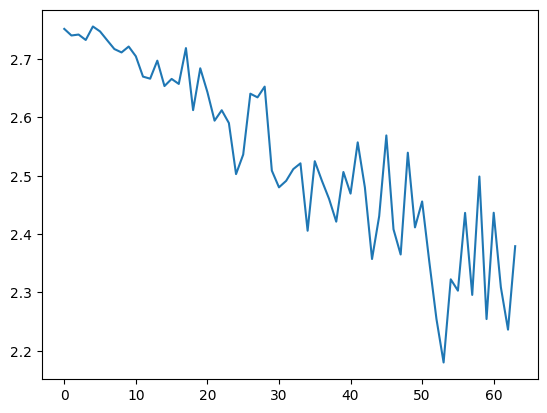

In [34]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()